In [2]:
#!/usr/bin/env python

import healpy as hp
import numpy as np
import fitsio
import glob
import statistics as st
import os

from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib


from desiutil.plots import prepare_data, init_sky, plot_grid_map, plot_healpix_map, plot_sky_circles, plot_sky_binned
from functions import compute_density_bin, plot_curve_density, plot_map, plot_histogram_bin, match_hpx_index, compute_density_bin_with_hpxlist
from desitarget.randoms import pixweight
from isdes import get_isdes

This notebook shows results from the Monte-Carlo simulation in terms of density (angular density, variations with depth or extinction...). The input table tMC is the output of the MC_{decam_ or nz_}parallelize_script.py and it is compared to the target density in DR9.

In [3]:
nside = 256
nested = True
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
print("pixel area = {:.2f} square degree".format(pix_area))

pixel area = 0.05 square degree


In [4]:
matplotlib.rcParams["figure.figsize"] = (12,8)

# 1 - Preprocess the tables

The first part aims to load the tables (DR9, Guadalupe data of the main DESI survey, the simulated density map) and to preprocess them.

## Load the DR9 and Guadalupe tables : 1 for targets, 2 for measured ELGs

In [5]:
regions = ["Total", "North", "South"]

# Tables 1: ELG targets
# Tables 2: real z-measured ELGs from Guadalupe

# ----- Load and read the files -----

print("reading tables 1 ...")
filename="maps-data/elg-lop-dr9-map-100-{}.csv".format(nside)
t1=Table.read(filename)
print("read",filename)
print(t1.dtype.names)

filename="maps-data/elg-lop-north-dr9-map-100-{}.csv".format(nside)
t1N=Table.read(filename)
print("read",filename)
print(t1N.dtype.names)

filename="maps-data/elg-lop-south-dr9-map-100-{}.csv".format(nside)
t1S=Table.read(filename)
print("read",filename)
print(t1S.dtype.names)

print("reading tables 2 ...")
filename="maps-data/elg-lop-guadalupe-map-100-{}.csv".format(nside)
t2=Table.read(filename)
print("read",filename)
print(t2.dtype.names)

filename="maps-data/elg-lop-guadalupe-north-map-100-{}.csv".format(nside)
t2N=Table.read(filename)
print("read",filename)
print(t2N.dtype.names)

filename="maps-data/elg-lop-guadalupe-south-discard-map-100-{}.csv".format(nside)
t2S=Table.read(filename)
print("read",filename)
print(t2S.dtype.names)

reading tables 1 ...
read maps-data/elg-lop-dr9-map-100-256.csv
('HPXPIXEL', 'RA', 'DEC', 'EBV', 'MW_TRANSMISSION_G', 'NOBS_G', 'FRACMASKED_G', 'FRACIN_G', 'PSFDEPTH_G', 'GALDEPTH_G', 'MW_TRANSMISSION_R', 'NOBS_R', 'FRACMASKED_R', 'FRACIN_R', 'PSFDEPTH_R', 'GALDEPTH_R', 'MW_TRANSMISSION_Z', 'NOBS_Z', 'FRACMASKED_Z', 'FRACIN_Z', 'PSFDEPTH_Z', 'GALDEPTH_Z', 'N_ELG_LOP')
read maps-data/elg-lop-north-dr9-map-100-256.csv
('HPXPIXEL', 'RA', 'DEC', 'EBV', 'MW_TRANSMISSION_G', 'NOBS_G', 'FRACMASKED_G', 'FRACIN_G', 'PSFDEPTH_G', 'GALDEPTH_G', 'MW_TRANSMISSION_R', 'NOBS_R', 'FRACMASKED_R', 'FRACIN_R', 'PSFDEPTH_R', 'GALDEPTH_R', 'MW_TRANSMISSION_Z', 'NOBS_Z', 'FRACMASKED_Z', 'FRACIN_Z', 'PSFDEPTH_Z', 'GALDEPTH_Z', 'N_ELG_LOP')
read maps-data/elg-lop-south-dr9-map-100-256.csv
('HPXPIXEL', 'RA', 'DEC', 'EBV', 'MW_TRANSMISSION_G', 'NOBS_G', 'FRACMASKED_G', 'FRACIN_G', 'PSFDEPTH_G', 'GALDEPTH_G', 'MW_TRANSMISSION_R', 'NOBS_R', 'FRACMASKED_R', 'FRACIN_R', 'PSFDEPTH_R', 'GALDEPTH_R', 'MW_TRANSMISSION_

### Check pixel weights

In [6]:
print("reading pixel weights ...")
filename="maps-data/pixweigths-dark-dr9.csv"
tpix=Table.read(filename)
print("read",filename)
print(tpix.dtype.names)
#tpix=tpix[np.where(tpix["FRACAREA"]>0)]
print(len(tpix))

reading pixel weights ...
read maps-data/pixweigths-dark-dr9.csv
('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'FRACAREA_12290', 'FRACAREA_8194', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY', 'REGION', 'RA', 'DEC')
786432


### Match DR9 with Guadalupe and pixel_weights tables with "HPXPIXEL"

In [7]:
match_hpx_index(t1, t2, ["EBV", "GALDEPTH_G", "GALDEPTH_R", "GALDEPTH_Z"], "LS")
match_hpx_index(t1N, t2N, ["EBV", "GALDEPTH_G", "GALDEPTH_R", "GALDEPTH_Z"], "LS")
match_hpx_index(t1S, t2S, ["EBV", "GALDEPTH_G", "GALDEPTH_R", "GALDEPTH_Z"], "LS")

In [8]:
match_hpx_index(tpix, t1, ["FRACAREA", "FRACAREA_12290", "EBV", "GALDEPTH_G", "GALDEPTH_R", "GALDEPTH_Z", "PSFDEPTH_G", "PSFDEPTH_R", "PSFDEPTH_Z", "PSFSIZE_G", "PSFSIZE_R", "PSFSIZE_Z"], "LS")
match_hpx_index(tpix, t1N, ["FRACAREA", "FRACAREA_12290", "EBV", "GALDEPTH_G", "GALDEPTH_R", "GALDEPTH_Z"], "LS")
match_hpx_index(tpix, t1S, ["FRACAREA", "FRACAREA_12290", "EBV", "GALDEPTH_G", "GALDEPTH_R", "GALDEPTH_Z"], "LS")

In [9]:
t1 = t1[np.where((t1["FRACAREA_in_LS"]>0.9) & (t1["DEC"]>-30))]
t1N = t1N[np.where(t1N["FRACAREA_in_LS"]>0.9)]
t1S = t1S[np.where((t1S["FRACAREA_in_LS"]>0.9) & (t1S["DEC"]>-30))]

In [10]:
theta, phi = hp.pix2ang(nside, hp.ang2pix(nside, np.radians(90-t1S["DEC"]), np.radians(t1S["RA"]), nest=False), nest=False)
des = get_isdes(np.degrees(phi), 90 - np.degrees(theta), nside)
not_des = [False if d else True for d in des]
t1Sdes = t1S[des]
t1Sdecals = t1S[not_des]

Defaulting to user installation because normal site-packages is not writeable


## Load the simulated Healpix map

In [71]:
print("reading Monte-Carlo results ...")
filename="MC_results/MC_decam_0.csv"
tmc=Table.read(filename)
print("read",filename)
print(tmc.dtype.names)
#tpix=tpix[np.where(tpix["FRACAREA"]>0)]
print(len(tmc))

reading Monte-Carlo results ...
read MC_results/MC_decam_0.csv
('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'FRACAREA_12290', 'FRACAREA_8194', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY', 'REGION', 'RA', 'DEC', 'NELG0', 'DETECTED', 'NELG')
310596


### Separate DES and DECaLS

In [72]:
from astropy import units as u
from astropy.coordinates import SkyCoord
coord = SkyCoord(ra=tmc["RA"], dec=tmc["DEC"], unit='deg')
coordgal = coord.galactic

In [73]:
coordS = SkyCoord(ra=t1S["RA"], dec=t1S["DEC"], unit='deg').galactic
tab2study = t1S[np.where(coordS.b.degree>=0)]

In [74]:
dec2rm = tab2study["DEC"]
dec2rm = dec2rm[np.where((dec2rm>32.3) & (dec2rm<32.5))]
print(np.max(dec2rm))

32.35658318665815


In [75]:
tmcN = tmc[np.where((coordgal.b.degree>=0) & (tmc["DEC"]>32.356))]
tmcS = tmc[np.where((coordgal.b.degree<0) | ((coordgal.b.degree>=0) & (tmc["DEC"]<32.356)))]
theta, phi = hp.pix2ang(nside, hp.ang2pix(nside, np.radians(90-tmcS["DEC"]), np.radians(tmcS["RA"]), nest=False), nest=False)
des = get_isdes(np.degrees(phi), 90 - np.degrees(theta), nside)
not_des = [False if d else True for d in des]
tmcSdes = tmcS[des]
tmcSdecals = tmcS[not_des]

Defaulting to user installation because normal site-packages is not writeable


t1reduced is the table with DR9 data but only on the healpixels that the simulated table tmc contains.

In [76]:
reducedhpx = [True if (t1["HPXPIXEL"][i] in tmc["HPXPIXEL"]) else False for i in range(len(t1))]
t1reduced = t1[reducedhpx]
print(len(t1reduced))

310596


# 2 - Angular density

The ELG density is the number of ELG in the healpixel / by its area (0.05 deg^2). However, to account for the reduction in the area by the veto masks, we use an effective area which is the area of the Healpixel ponderated by the fraction of the surface that is not covered by the ELG masks.

In [77]:
def eff_area(t, name=''):
    return pix_area*t["FRACAREA_12290" + name]/t["FRACAREA" + name]

In [78]:
density_1N = t1N["N_ELG_LOP"]/eff_area(t1N, '_in_LS')
density_1S = t1S["N_ELG_LOP"]/eff_area(t1S, '_in_LS')
density_1Sdes = t1Sdes["N_ELG_LOP"]/eff_area(t1Sdes, '_in_LS')
density_1Sdecals = t1Sdecals["N_ELG_LOP"]/eff_area(t1Sdecals, '_in_LS')
density1 = t1["N_ELG_LOP"]/eff_area(t1, '_in_LS')

dens0mc = tmc["NELG0"]/eff_area(tmc)
densmc0N = tmcN["NELG0"]/eff_area(tmcN)
densmc0Sdes = tmcSdes["NELG0"]/eff_area(tmcSdes)
densmc0Sdecals = tmcSdecals["NELG0"]/eff_area(tmcSdecals)
densmc = tmc["NELG"]/eff_area(tmc)
densmcN = tmcN["NELG"]/eff_area(tmcN)
densmcSdes = tmcSdes["NELG"]/eff_area(tmcSdes)
densmcSdecals = tmcSdecals["NELG"]/eff_area(tmcSdecals)

print("North density in DR9: " + str(np.mean(density_1N)) + " deg-2")
print("South DES density in DR9: " + str(np.mean(density_1Sdes)) + " deg-2")
print("South DECaLS density in DR9: " + str(np.mean(density_1Sdecals)) + " deg-2")
print("Total density in DR9: " + str(np.mean(density1)) + " deg-2")

print("")
print("AVERAGE SIMULATED DENSITY")
print("North density MC: " + str(np.mean(densmcN)) + " deg-2")
print("South DES density MC: " + str(np.mean(densmcSdes)) + " deg-2")
print("South DECaLS density MC: " + str(np.mean(densmcSdecals)) + " deg-2")
print("Total density MC: " + str(np.mean(densmc)) + " deg-2")

North density in DR9: 1928.1493044620834 deg-2
South DES density in DR9: 1928.8831563365545 deg-2
South DECaLS density in DR9: 1965.4797951985438 deg-2
Total density in DR9: 1955.6383802423431 deg-2

AVERAGE SIMULATED DENSITY
North density MC: 1601.9408081233448 deg-2
South DES density MC: 1409.5718231248793 deg-2
South DECaLS density MC: 1458.0305855978538 deg-2
Total density MC: 1497.0152986556402 deg-2


0.036424646519211124
1513.8588504892853


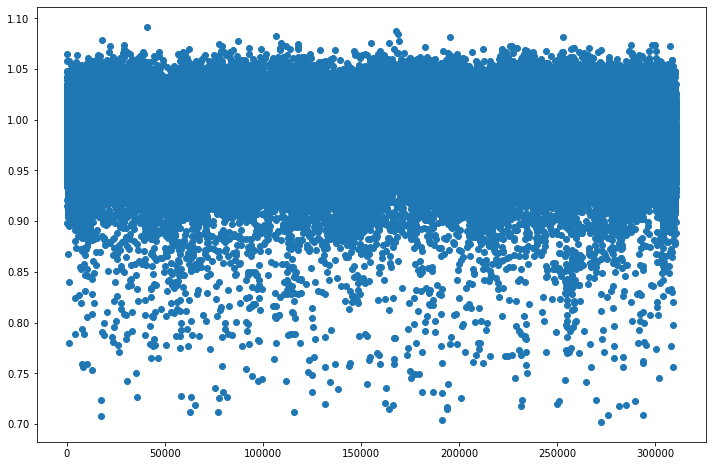

In [79]:
plt.plot(tmc["FRACAREA_12290"], 'o')
print(np.min(eff_area(tmc)))
print(np.mean(tmcSdecals["NELG"]/0.05))

## DR9 density

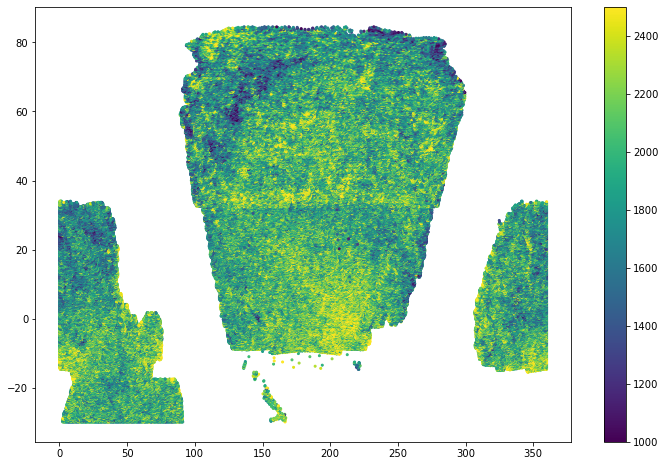

In [80]:
plt.figure("elg-density")
plt.scatter(t1reduced["RA"],t1reduced["DEC"],c=t1reduced["N_ELG_LOP"]/eff_area(t1reduced, '_in_LS'),  vmin=1000, vmax=2500, s=4)
plt.colorbar()

## Simulated density

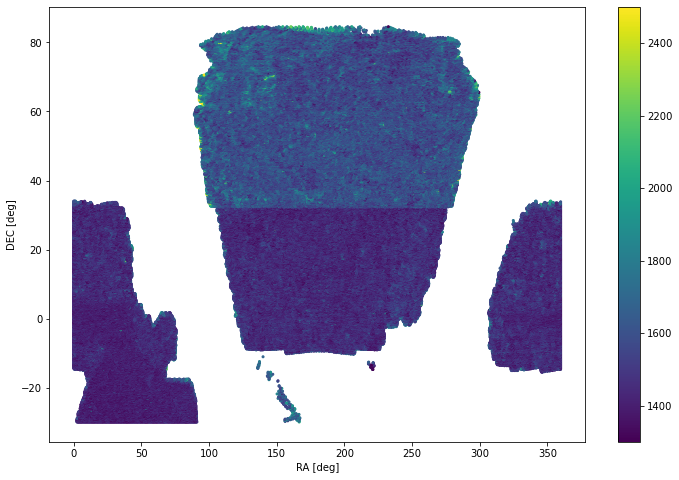

In [81]:
plt.scatter(tmc["RA"],tmc["DEC"],c=densmc, vmin=1300, vmax=2500, s=4)
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.colorbar()

# 3 - Density fluctuations with depth, EBV and seeing

In this section, the plots of Anand's paper "The DESI Emission Line Galaxy sample: target selection and validation" are reproduced: the DR9 data and the simulated data are compared. The plots show the density fluctuations vs. depth, psf_size and extinction. In each case, the thick line depicts the mean value over the bin of at least 100 healpixels and the transparent area around the curve show the standard deviation. The histograms show the number of healpixels in each bin. The functions used here to bin the values are described in functions.py.

In [82]:
# Mean values of density

all_healpixels=np.arange(hp.nside2npix(nside))

h2i={h:i for i,h in enumerate(t1N["HPXPIXEL"])}
jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
mean_density_1N = np.mean(density_1N[jj[jj>=0]])
h2i={h:i for i,h in enumerate(t1Sdes["HPXPIXEL"])}
jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
mean_density_1Sdes = np.mean(density_1Sdes[jj[jj>=0]])
h2i={h:i for i,h in enumerate(t1Sdecals["HPXPIXEL"])}
jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
mean_density_1Sdecals = np.mean(density_1Sdecals[jj[jj>=0]]) 

h2i={h:i for i,h in enumerate(tmcN["HPXPIXEL"])}
jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
mean_density_mcfN = np.mean(densmcN[jj[jj>=0]])
h2i={h:i for i,h in enumerate(tmcSdes["HPXPIXEL"])}
jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
mean_density_mcfSdes = np.mean(densmcSdes[jj[jj>=0]])
h2i={h:i for i,h in enumerate(tmcSdecals["HPXPIXEL"])}
jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
mean_density_mcfSdecals = np.mean(densmcSdecals[jj[jj>=0]]) 

# h2i={h:i for i,h in enumerate(t2N["HPXPIXEL"])}
# jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
# mean_density_2N = np.mean(density_2N[jj[jj>=0]])
# h2i={h:i for i,h in enumerate(t2S["HPXPIXEL"])}
# jj=np.array([h2i[h] if h in h2i else -1 for h in all_healpixels])
# mean_density_2S = np.mean(density_2S[jj[jj>=0]])     

## Extinction

Text(0, 0.5, 'Nb of healpixels')

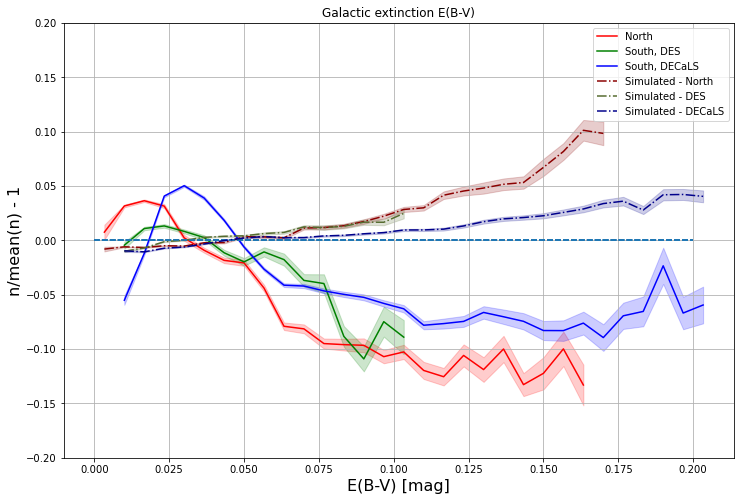

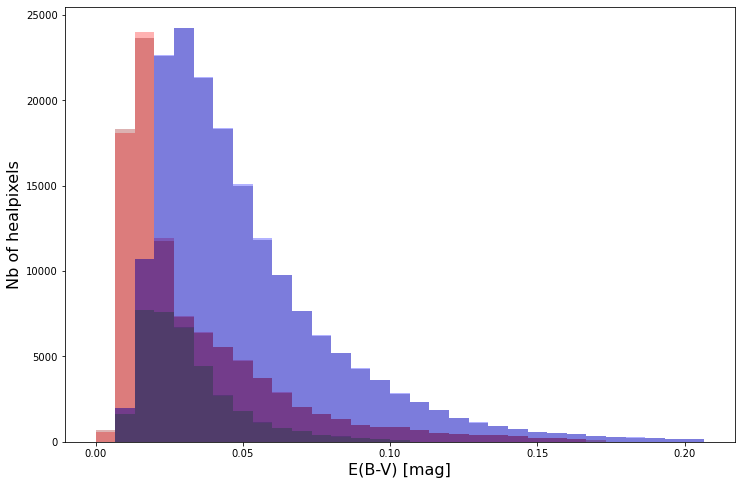

In [83]:
"""EBV"""

plt.figure()
plt.title("Galactic extinction E(B-V)")

min_x = 0.
max_x = 0.2
binsize = (max_x-min_x)/30
minbin = 100

x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N = compute_density_bin(density_1N, t1N["EBV"], min_x, max_x, binsize, mean_density_1N, minbin)
plot_curve_density(x_axis_1N, mean_value_1N, std_value_1N, min_x, max_x, -0.5, 0.5, 'r', 'North')
x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, nb_pix_1Sdes = compute_density_bin(density_1Sdes, t1Sdes["EBV"], min_x, max_x, binsize, mean_density_1Sdes, minbin)
plot_curve_density(x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, min_x, max_x, -0.5, 0.5, 'g', 'South, DES')
x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, nb_pix_1Sdecals = compute_density_bin(density_1Sdecals, t1Sdecals["EBV"], min_x, max_x, binsize, mean_density_1Sdecals, minbin)
plot_curve_density(x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, min_x, max_x, -0.5, 0.5, 'b', 'South, DECaLS')

x_axis_mcN, mean_value_mcN, std_value_mcN, nb_pix_mcN = compute_density_bin(densmcN, tmcN["EBV"], min_x, max_x, binsize, mean_density_mcfN, minbin)
plot_curve_density(x_axis_mcN, mean_value_mcN, std_value_mcN, min_x, max_x, -0.5, 0.5, 'darkred',  'Simulated - North', linestyle='dashdot')
x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, nb_pix_mcSdes = compute_density_bin(densmcSdes, tmcSdes["EBV"], min_x, max_x, binsize, mean_density_mcfSdes, minbin)
plot_curve_density(x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, min_x, max_x, -0.5, 0.5, 'darkolivegreen',  'Simulated - DES', linestyle='dashdot')
x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, nb_pix_mcSdecals = compute_density_bin(densmcSdecals, tmcSdecals["EBV"], min_x, max_x, binsize, mean_density_mcfSdecals, minbin)
plot_curve_density(x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, min_x, max_x, -0.5, 0.5, 'darkblue',  'Simulated - DECaLS', linestyle='dashdot')

# x_axis_2N, mean_value_2N, std_value_2N, nb_pix_2N = compute_density_bin(t2N, t2N["EBV_in_1"], min_x, max_x, binsize, mean_density_2N)
# plot_curve_density(x_axis_2N, mean_value_2N, std_value_2N, min_x, max_x, -0.5, 0.5, 'g')
# x_axis_2S, mean_value_2S, std_value_2S, nb_pix_2S = compute_density_bin(t2S, t2S["EBV_in_1"], min_x, max_x, binsize, mean_density_2S)
# plot_curve_density(x_axis_2S, mean_value_2S, std_value_2S, min_x, max_x, -0.5, 0.5, 'y')

plt.grid(True)
plt.ylim(-0.2,0.2)
plt.xlabel("E(B-V) [mag]", size=16)
plt.ylabel("n/mean(n) - 1", size=16)
plt.legend()
#plt.savefig('ebv.png', bbox_inches='tight')

plt.figure()
plot_histogram_bin(x_axis_1N, nb_pix_1N, binsize, color='r')
plot_histogram_bin(x_axis_1Sdes, nb_pix_1Sdes, binsize, color='g')
plot_histogram_bin(x_axis_1Sdecals, nb_pix_1Sdecals, binsize, color='b')
plot_histogram_bin(x_axis_mcN, nb_pix_mcN, binsize, color='darkred')
plot_histogram_bin(x_axis_mcSdes, nb_pix_mcSdes, binsize, color='darkolivegreen')
plot_histogram_bin(x_axis_mcSdecals, nb_pix_mcSdecals, binsize, color='darkblue')
# plot_histogram_bin(x_axis_2N, nb_pix_2N, binsize, color='g')
# plot_histogram_bin(x_axis_2S, nb_pix_2S, binsize, color='y')

plt.xlabel("E(B-V) [mag]", size=16)
plt.ylabel("Nb of healpixels", size=16)
#plt.savefig('ebv-bins.png', bbox_inches='tight')

## g-band Galaxy depth

Text(0, 0.5, 'Nb of healpixels')

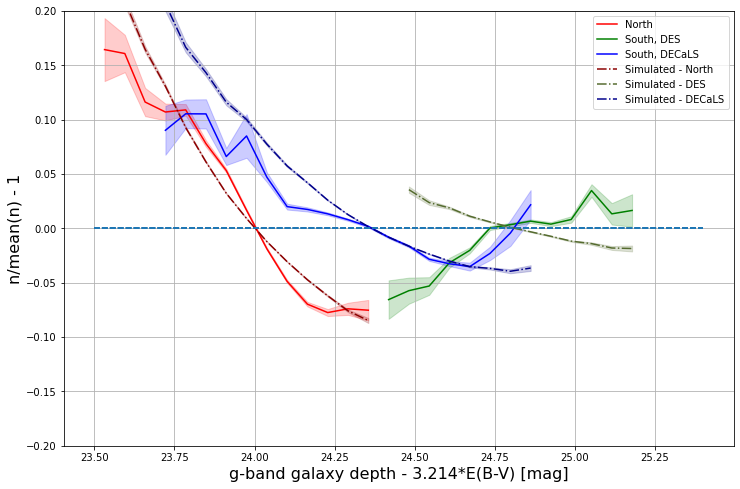

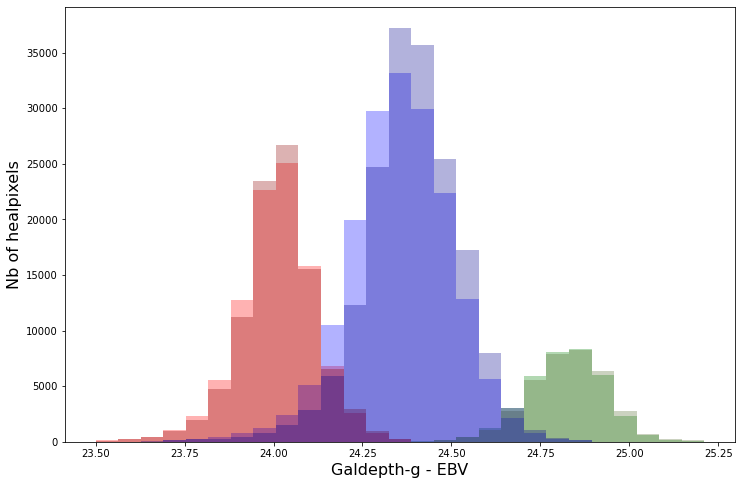

In [84]:
"""Galay depth g - 3.214*EBV"""

plt.figure()

min_x = 23.5
max_x = 25.4
binsize = (max_x-min_x)/30

#x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N, hpx_list = compute_density_bin_with_hpxlist(density_1N, -2.5 * (np.log10(5/np.sqrt(t1N["GALDEPTH_G"])) - 9)-3.214*t1N["EBV"], min_x, max_x, binsize, pix_area, mean_density_1N, minbin)
x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N = compute_density_bin(density_1N, 22.5-2.5 * np.log10(5/np.sqrt(t1N["GALDEPTH_G"]))-3.214*t1N["EBV"], min_x, max_x, binsize, mean_density_1N, minbin)
plot_curve_density(x_axis_1N, mean_value_1N, std_value_1N, min_x, max_x, -0.5, 0.5, 'r', 'North')
x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, nb_pix_1Sdes = compute_density_bin(density_1Sdes, 22.5-2.5 * np.log10(5/np.sqrt(t1Sdes["GALDEPTH_G"]))-3.214*t1Sdes["EBV"], min_x, max_x, binsize, mean_density_1Sdes, minbin)
plot_curve_density(x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, min_x, max_x, -0.5, 0.5, 'g', 'South, DES')
x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, nb_pix_1Sdecals = compute_density_bin(density_1Sdecals, 22.5-2.5 * np.log10(5/np.sqrt(t1Sdecals["GALDEPTH_G"]))-3.214*t1Sdecals["EBV"], min_x, max_x, binsize, mean_density_1Sdecals, minbin)
plot_curve_density(x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, min_x, max_x, -0.5, 0.5, 'b', 'South, DECaLS')

x_axis_mcN, mean_value_mcN, std_value_mcN, nb_pix_mcN = compute_density_bin(densmcN, 22.5-2.5 * np.log10(5/np.sqrt(tmcN["GALDEPTH_G"]))-3.214*tmcN["EBV"], min_x, max_x, binsize, mean_density_mcfN, minbin)
plot_curve_density(x_axis_mcN, mean_value_mcN, std_value_mcN, min_x, max_x, -0.5, 0.5, 'darkred',  'Simulated - North', 'dashdot')
x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, nb_pix_mcSdes = compute_density_bin(densmcSdes, 22.5-2.5 * np.log10(5/np.sqrt(tmcSdes["GALDEPTH_G"]))-3.214*tmcSdes["EBV"], min_x, max_x, binsize, mean_density_mcfSdes, minbin)
plot_curve_density(x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, min_x, max_x, -0.5, 0.5, 'darkolivegreen',  'Simulated - DES', 'dashdot')
x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, nb_pix_mcSdecals = compute_density_bin(densmcSdecals, 22.5-2.5 * np.log10(5/np.sqrt(tmcSdecals["GALDEPTH_G"]))-3.214*tmcSdecals["EBV"], min_x, max_x, binsize, mean_density_mcfSdecals, minbin)
plot_curve_density(x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, min_x, max_x, -0.5, 0.5, 'darkblue', 'Simulated - DECaLS', 'dashdot')

# x_axis_2N, mean_value_2N, std_value_2N, nb_pix_2N = compute_density_bin(density_2N, -2.5 * (np.log10(5/np.sqrt(t2N["GALDEPTH_G_in_LS"])) - 9)-3.214*t2N["EBV_in_LS"], min_x, max_x, binsize, mean_density_2N, 200)
# plot_curve_density(x_axis_2N, mean_value_2N, std_value_2N, min_x, max_x, -0.5, 0.5, 'orange', 'Guadalupe - North')
# x_axis_2S, mean_value_2S, std_value_2S, nb_pix_2S = compute_density_bin(density_2S, -2.5 * (np.log10(5/np.sqrt(t2S["GALDEPTH_G_in_LS"])) - 9)-3.214*t2S["EBV_in_LS"], min_x, max_x, binsize, mean_density_2S, 200)
# plot_curve_density(x_axis_2S, mean_value_2S, std_value_2S, min_x, max_x, -0.5, 0.5, 'y', 'Guadalupe - South')

plt.grid(True)
plt.ylim(-0.2,0.2)
plt.xlabel("g-band galaxy depth - 3.214*E(B-V) [mag]", size=16)
plt.ylabel("n/mean(n) - 1", size=16)
plt.legend()
# plt.savefig('galdepth-g.png', bbox_inches='tight')

plt.figure()
plot_histogram_bin(x_axis_1N, nb_pix_1N, binsize, color='r')
plot_histogram_bin(x_axis_1Sdes, nb_pix_1Sdes, binsize, color='g')
plot_histogram_bin(x_axis_1Sdecals, nb_pix_1Sdecals, binsize, color='b')
plot_histogram_bin(x_axis_mcN, nb_pix_mcN, binsize, color='darkred')
plot_histogram_bin(x_axis_mcSdes, nb_pix_mcSdes, binsize, color='darkolivegreen')
plot_histogram_bin(x_axis_mcSdecals, nb_pix_mcSdecals, binsize, color='darkblue')
# plot_histogram_bin(x_axis_2N, nb_pix_2N, binsize, color='orange')
# plot_histogram_bin(x_axis_2S, nb_pix_2S, binsize, color='y')

plt.xlabel("Galdepth-g - EBV", size=16)
plt.ylabel("Nb of healpixels", size=16)
#plt.savefig('galdepth-g-bins.png', bbox_inches='tight')

## r-band Galaxy depth

Text(0, 0.5, 'Nb of healpixels')

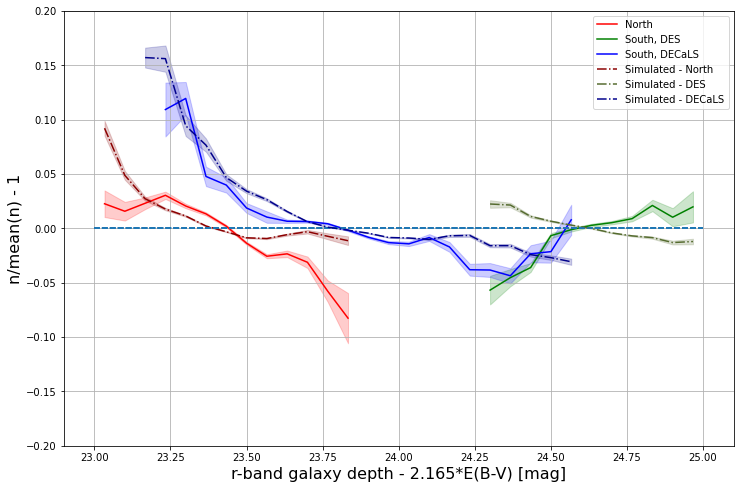

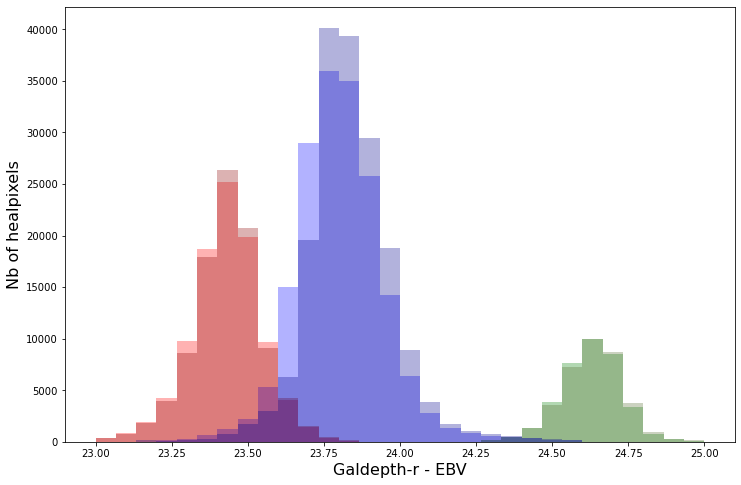

In [85]:
"""Galay depth r - 2.165*EBV"""

plt.figure()

min_x = 23.
max_x = 25.
binsize = (max_x-min_x)/30

x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N = compute_density_bin(density_1N, -2.5 * (np.log10(5/np.sqrt(t1N["GALDEPTH_R"])) - 9)-2.165*t1N["EBV"], min_x, max_x, binsize, mean_density_1N, minbin)
plot_curve_density(x_axis_1N, mean_value_1N, std_value_1N, min_x, max_x, -0.5, 0.5, 'r', 'North')
x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, nb_pix_1Sdes = compute_density_bin(density_1Sdes, -2.5 * (np.log10(5/np.sqrt(t1Sdes["GALDEPTH_R"])) - 9)-2.165*t1Sdes["EBV"], min_x, max_x, binsize, mean_density_1Sdes, minbin)
plot_curve_density(x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, min_x, max_x, -0.5, 0.5, 'g',  'South, DES')
x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, nb_pix_1Sdecals = compute_density_bin(density_1Sdecals, -2.5 * (np.log10(5/np.sqrt(t1Sdecals["GALDEPTH_R"])) - 9)-2.165*t1Sdecals["EBV"], min_x, max_x, binsize, mean_density_1Sdecals, minbin)
plot_curve_density(x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, min_x, max_x, -0.5, 0.5, 'b',  'South, DECaLS')

x_axis_mcN, mean_value_mcN, std_value_mcN, nb_pix_mcN = compute_density_bin(densmcN, -2.5 * (np.log10(5/np.sqrt(tmcN["GALDEPTH_R"])) - 9)-2.165*tmcN["EBV"], min_x, max_x, binsize, mean_density_mcfN, minbin)
plot_curve_density(x_axis_mcN, mean_value_mcN, std_value_mcN, min_x, max_x, -0.5, 0.5, 'darkred',  'Simulated - North', 'dashdot')
x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, nb_pix_mcSdes = compute_density_bin(densmcSdes, -2.5 * (np.log10(5/np.sqrt(tmcSdes["GALDEPTH_R"])) - 9)-2.165*tmcSdes["EBV"], min_x, max_x, binsize, mean_density_mcfSdes, minbin)
plot_curve_density(x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, min_x, max_x, -0.5, 0.5, 'darkolivegreen',  'Simulated - DES', 'dashdot')
x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, nb_pix_mcSdecals = compute_density_bin(densmcSdecals, -2.5 * (np.log10(5/np.sqrt(tmcSdecals["GALDEPTH_R"])) - 9)-2.165*tmcSdecals["EBV"], min_x, max_x, binsize, mean_density_mcfSdecals, minbin)
plot_curve_density(x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, min_x, max_x, -0.5, 0.5, 'darkblue',  'Simulated - DECaLS', 'dashdot')

# x_axis_2N, mean_value_2N, std_value_2N, nb_pix_2N = compute_density_bin(density_2N, -2.5 * (np.log10(5/np.sqrt(t2N["GALDEPTH_R_in_LS"])) - 9)-2.165*t2N["EBV_in_LS"], min_x, max_x, binsize, mean_density_2N, 200)
# plot_curve_density(x_axis_2N, mean_value_2N, std_value_2N, min_x, max_x, -0.5, 0.5, 'orange', 'Guadalupe - North')
# x_axis_2S, mean_value_2S, std_value_2S, nb_pix_2S = compute_density_bin(density_2S, -2.5 * (np.log10(5/np.sqrt(t2S["GALDEPTH_R_in_LS"])) - 9)-2.165*t2S["EBV_in_LS"], min_x, max_x, binsize, mean_density_2S, 200)
# plot_curve_density(x_axis_2S, mean_value_2S, std_value_2S, min_x, max_x, -0.5, 0.5, 'y', 'Guadalupe - South')

plt.grid(True)
plt.ylim(-0.2,0.2)
plt.xlabel("r-band galaxy depth - 2.165*E(B-V) [mag]", size=16)
plt.ylabel("n/mean(n) - 1", size=16)
plt.legend()
# plt.savefig('galdepth-r.png', bbox_inches='tight')

plt.figure()
plot_histogram_bin(x_axis_1N, nb_pix_1N, binsize, color='r')
plot_histogram_bin(x_axis_1Sdes, nb_pix_1Sdes, binsize, color='g')
plot_histogram_bin(x_axis_1Sdecals, nb_pix_1Sdecals, binsize, color='b')
plot_histogram_bin(x_axis_mcN, nb_pix_mcN, binsize, color='darkred')
plot_histogram_bin(x_axis_mcSdes, nb_pix_mcSdes, binsize, color='darkolivegreen')
plot_histogram_bin(x_axis_mcSdecals, nb_pix_mcSdecals, binsize, color='darkblue')
# plot_histogram_bin(x_axis_2N, nb_pix_2N, binsize, color='g')
# plot_histogram_bin(x_axis_2S, nb_pix_2S, binsize, color='y')

plt.xlabel("Galdepth-r - EBV", size=16)
plt.ylabel("Nb of healpixels", size=16)
#plt.savefig('galdepth-r-bins.png', bbox_inches='tight')

## z-band Galaxy depth

Text(0, 0.5, 'Nb of healpixels')

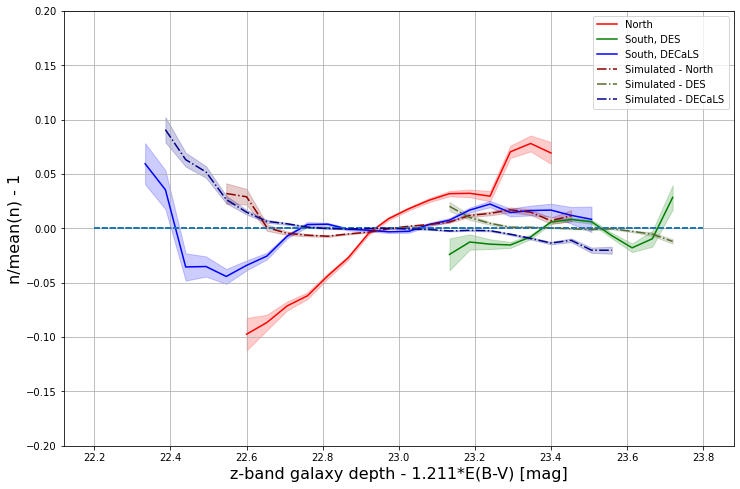

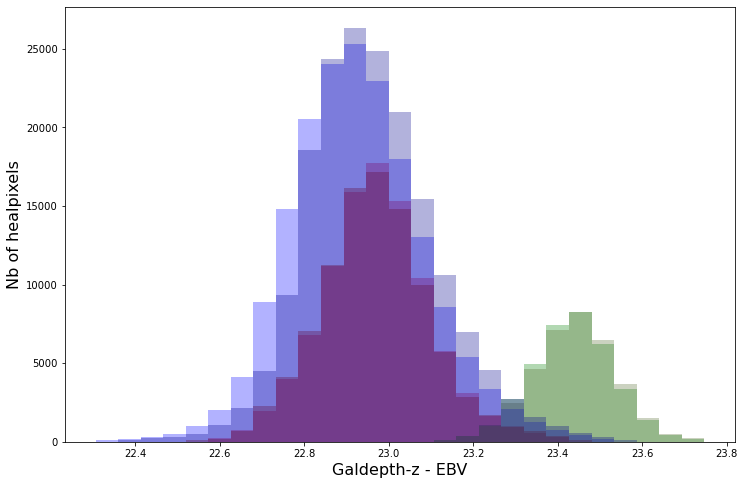

In [86]:
"""Galay depth z - 1.211*EBV"""

plt.figure()

min_x = 22.2
max_x = 23.8
binsize = (max_x-min_x)/30

x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N = compute_density_bin(density_1N, -2.5 * (np.log10(5/np.sqrt(t1N["GALDEPTH_Z"])) - 9)-1.211*t1N["EBV"], min_x, max_x, binsize, mean_density_1N, minbin)
plot_curve_density(x_axis_1N, mean_value_1N, std_value_1N, min_x, max_x, -0.5, 0.5, 'r', 'North')
x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, nb_pix_1Sdes = compute_density_bin(density_1Sdes, 22.5-2.5 * np.log10(5/np.sqrt(t1Sdes["GALDEPTH_Z"]))-1.211*t1Sdes["EBV"], min_x, max_x, binsize, mean_density_1Sdes, minbin)
plot_curve_density(x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, min_x, max_x, -0.5, 0.5, 'g', 'South, DES')
x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, nb_pix_1Sdecals = compute_density_bin(density_1Sdecals, -2.5 * (np.log10(5/np.sqrt(t1Sdecals["GALDEPTH_Z"])) - 9)-1.211*t1Sdecals["EBV"], min_x, max_x, binsize, mean_density_1Sdecals, minbin)
plot_curve_density(x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, min_x, max_x, -0.5, 0.5, 'b', 'South, DECaLS')

x_axis_mcN, mean_value_mcN, std_value_mcN, nb_pix_mcN = compute_density_bin(densmcN, -2.5 * (np.log10(5/np.sqrt(tmcN["GALDEPTH_Z"])) - 9)-1.211*tmcN["EBV"], min_x, max_x, binsize, mean_density_mcfN, minbin)
plot_curve_density(x_axis_mcN, mean_value_mcN, std_value_mcN, min_x, max_x, -0.5, 0.5, 'darkred',  'Simulated - North', 'dashdot')
x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, nb_pix_mcSdes = compute_density_bin(densmcSdes, -2.5 * (np.log10(5/np.sqrt(tmcSdes["GALDEPTH_Z"])) - 9)-1.211*tmcSdes["EBV"], min_x, max_x, binsize, mean_density_mcfSdes, minbin)
plot_curve_density(x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, min_x, max_x, -0.5, 0.5, 'darkolivegreen',  'Simulated - DES', 'dashdot')
x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, nb_pix_mcSdecals = compute_density_bin(densmcSdecals, -2.5 * (np.log10(5/np.sqrt(tmcSdecals["GALDEPTH_Z"])) - 9)-1.211*tmcSdecals["EBV"], min_x, max_x, binsize, mean_density_mcfSdecals, minbin)
plot_curve_density(x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, min_x, max_x, -0.5, 0.5, 'darkblue',  'Simulated - DECaLS', 'dashdot')

# x_axis_2N, mean_value_2N, std_value_2N, nb_pix_2N = compute_density_bin(density_2N, -2.5 * (np.log10(5/np.sqrt(t2N["GALDEPTH_Z_in_LS"])) - 9)-1.211*t2N["EBV_in_LS"], min_x, max_x, binsize, mean_density_2N, 200)
# plot_curve_density(x_axis_2N, mean_value_2N, std_value_2N, min_x, max_x, -0.5, 0.5, 'orange', 'Guadalupe - North')
# x_axis_2S, mean_value_2S, std_value_2S, nb_pix_2S = compute_density_bin(density_2S, -2.5 * (np.log10(5/np.sqrt(t2S["GALDEPTH_Z_in_LS"])) - 9)-1.211*t2S["EBV_in_LS"], min_x, max_x, binsize, mean_density_2S, 200)
# plot_curve_density(x_axis_2S, mean_value_2S, std_value_2S, min_x, max_x, -0.5, 0.5, 'y', 'Guadalupe - South')

plt.grid(True)
plt.ylim(-0.2,0.2)
plt.xlabel("z-band galaxy depth - 1.211*E(B-V) [mag]", size=16)
plt.ylabel("n/mean(n) - 1", size=16)
plt.legend()
# plt.savefig('galdepth-z.png', bbox_inches='tight')

plt.figure()
plot_histogram_bin(x_axis_1N, nb_pix_1N, binsize, color='r')
plot_histogram_bin(x_axis_1Sdes, nb_pix_1Sdes, binsize, color='g')
plot_histogram_bin(x_axis_1Sdecals, nb_pix_1Sdecals, binsize, color='b')
plot_histogram_bin(x_axis_mcN, nb_pix_mcN, binsize, color='darkred')
plot_histogram_bin(x_axis_mcSdes, nb_pix_mcSdes, binsize, color='darkolivegreen')
plot_histogram_bin(x_axis_mcSdecals, nb_pix_mcSdecals, binsize, color='darkblue')
# plot_histogram_bin(x_axis_2N, nb_pix_2N, binsize, color='g')
# plot_histogram_bin(x_axis_2S, nb_pix_2S, binsize, color='y')

plt.xlabel("Galdepth-z - EBV", size=16)
plt.ylabel("Nb of healpixels", size=16)
#plt.savefig('galdepth-z-bins.png', bbox_inches='tight')

## g-band PSF size

Text(0, 0.5, 'Nb of healpixels')

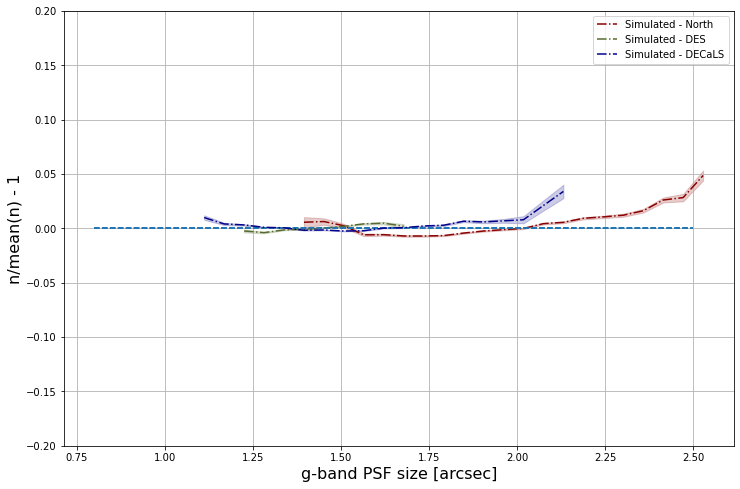

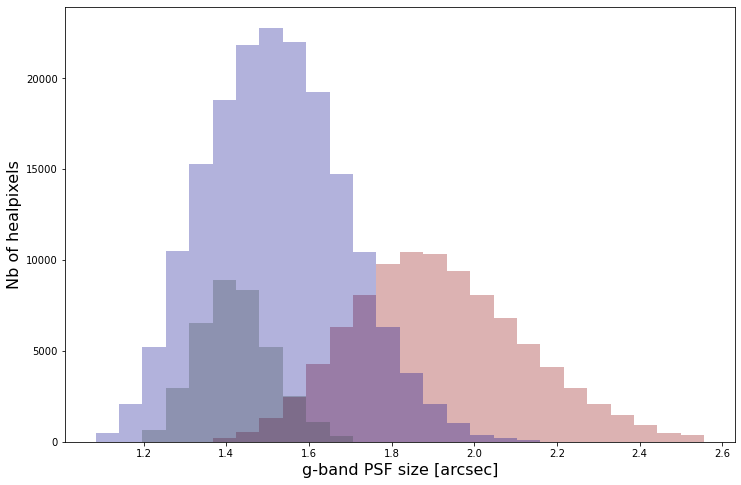

In [87]:
"""PSF size g"""

plt.figure()

min_x = 0.8
max_x = 2.50
binsize = (max_x-min_x)/30

# x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N = compute_density_bin(density_1N, t1N["PSFSIZE_G"], min_x, max_x, binsize, mean_density_1N, minbin)
# plot_curve_density(x_axis_1N, mean_value_1N, std_value_1N, min_x, max_x, -0.5, 0.5, 'r', 'North')
# x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, nb_pix_1Sdes = compute_density_bin(density_1Sdes, t1Sdes["PSFSIZE_G"], min_x, max_x, binsize, mean_density_1Sdes, minbin)
# plot_curve_density(x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, min_x, max_x, -0.5, 0.5, 'g', 'South, DES')
# x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, nb_pix_1Sdecals = compute_density_bin(density_1Sdecals, t1Sdecals["PSFSIZE_G"], min_x, max_x, binsize, mean_density_1Sdecals, minbin)
# plot_curve_density(x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, min_x, max_x, -0.5, 0.5, 'b', 'South, DECaLS')

x_axis_mcN, mean_value_mcN, std_value_mcN, nb_pix_mcN = compute_density_bin(densmcN, tmcN["PSFSIZE_G"], min_x, max_x, binsize, mean_density_mcfN, minbin)
plot_curve_density(x_axis_mcN, mean_value_mcN, std_value_mcN, min_x, max_x, -0.5, 0.5, 'darkred',  'Simulated - North', 'dashdot')
x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, nb_pix_mcSdes = compute_density_bin(densmcSdes, tmcSdes["PSFSIZE_G"], min_x, max_x, binsize, mean_density_mcfSdes, minbin)
plot_curve_density(x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, min_x, max_x, -0.5, 0.5, 'darkolivegreen',  'Simulated - DES', 'dashdot')
x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, nb_pix_mcSdecals = compute_density_bin(densmcSdecals, tmcSdecals["PSFSIZE_G"], min_x, max_x, binsize, mean_density_mcfSdecals, minbin)
plot_curve_density(x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, min_x, max_x, -0.5, 0.5, 'darkblue',  'Simulated - DECaLS', 'dashdot')

# x_axis_2N, mean_value_2N, std_value_2N, nb_pix_2N = compute_density_bin(density_2N, t2N["PSFSIZE_G"], min_x, max_x, binsize, mean_density_2N, 200)
# plot_curve_density(x_axis_2N, mean_value_2N, std_value_2N, min_x, max_x, -0.5, 0.5, 'orange', 'Guadalupe - North')
# x_axis_2S, mean_value_2S, std_value_2S, nb_pix_2S = compute_density_bin(density_2S, t2S, min_x, max_x, binsize, mean_density_2S, 200)
# plot_curve_density(x_axis_2S, mean_value_2S, std_value_2S, min_x, max_x, -0.5, 0.5, 'y', 'Guadalupe - South')

plt.grid(True)
plt.ylim(-0.2,0.2)
plt.xlabel("g-band PSF size [arcsec]", size=16)
plt.ylabel("n/mean(n) - 1", size=16)
plt.legend()
# plt.savefig('galdepth-z.png', bbox_inches='tight')

plt.figure()
# plot_histogram_bin(x_axis_1N, nb_pix_1N, binsize, color='r')
# plot_histogram_bin(x_axis_1Sdes, nb_pix_1Sdes, binsize, color='g')
# plot_histogram_bin(x_axis_1Sdecals, nb_pix_1Sdecals, binsize, color='b')
plot_histogram_bin(x_axis_mcN, nb_pix_mcN, binsize, color='darkred')
plot_histogram_bin(x_axis_mcSdes, nb_pix_mcSdes, binsize, color='darkolivegreen')
plot_histogram_bin(x_axis_mcSdecals, nb_pix_mcSdecals, binsize, color='darkblue')
# plot_histogram_bin(x_axis_2N, nb_pix_2N, binsize, color='g')
# plot_histogram_bin(x_axis_2S, nb_pix_2S, binsize, color='y')

plt.xlabel("g-band PSF size [arcsec]", size=16)
plt.ylabel("Nb of healpixels", size=16)
#plt.savefig('galdepth-z-bins.png', bbox_inches='tight')

## r-band PSF size

Text(0, 0.5, 'Nb of healpixels')

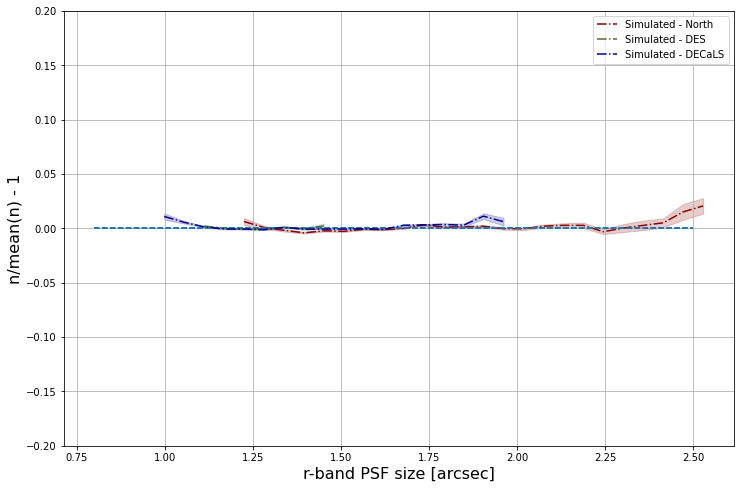

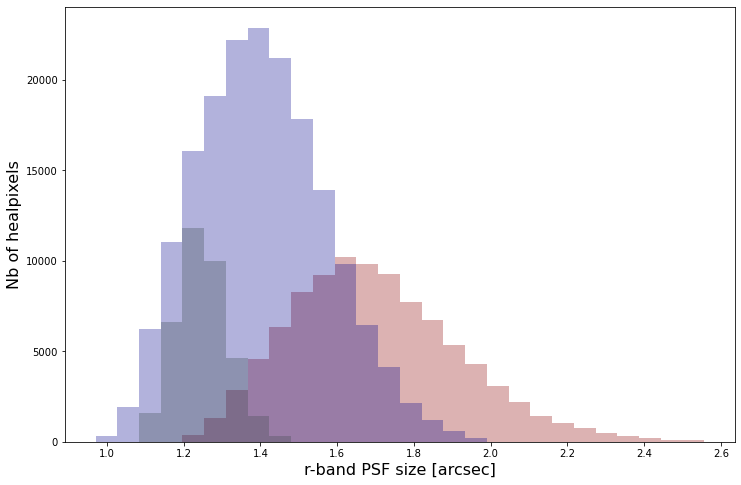

In [88]:
"""PSF size r"""

plt.figure()

min_x = 0.8
max_x = 2.50
binsize = (max_x-min_x)/30

# x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N = compute_density_bin(density_1N, t1N["PSFSIZE_R"], min_x, max_x, binsize, mean_density_1N, minbin)
# plot_curve_density(x_axis_1N, mean_value_1N, std_value_1N, min_x, max_x, -0.5, 0.5, 'r', 'North')
# x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, nb_pix_1Sdes = compute_density_bin(density_1Sdes, t1Sdes["PSFSIZE_R"], min_x, max_x, binsize, mean_density_1Sdes, minbin)
# plot_curve_density(x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, min_x, max_x, -0.5, 0.5, 'g', 'South, DES')
# x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, nb_pix_1Sdecals = compute_density_bin(density_1Sdecals, t1Sdecals["PSFSIZE_R"], min_x, max_x, binsize, mean_density_1Sdecals, minbin)
# plot_curve_density(x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, min_x, max_x, -0.5, 0.5, 'b', 'South, DECaLS')

x_axis_mcN, mean_value_mcN, std_value_mcN, nb_pix_mcN = compute_density_bin(densmcN, tmcN["PSFSIZE_R"], min_x, max_x, binsize, mean_density_mcfN, minbin)
plot_curve_density(x_axis_mcN, mean_value_mcN, std_value_mcN, min_x, max_x, -0.5, 0.5, 'darkred',  'Simulated - North', 'dashdot')
x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, nb_pix_mcSdes = compute_density_bin(densmcSdes, tmcSdes["PSFSIZE_R"], min_x, max_x, binsize, mean_density_mcfSdes, minbin)
plot_curve_density(x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, min_x, max_x, -0.5, 0.5, 'darkolivegreen',  'Simulated - DES', 'dashdot')
x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, nb_pix_mcSdecals = compute_density_bin(densmcSdecals, tmcSdecals["PSFSIZE_R"], min_x, max_x, binsize, mean_density_mcfSdecals, minbin)
plot_curve_density(x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, min_x, max_x, -0.5, 0.5, 'darkblue',  'Simulated - DECaLS', 'dashdot')

# x_axis_2N, mean_value_2N, std_value_2N, nb_pix_2N = compute_density_bin(density_2N, t2N["PSFSIZE_R"], min_x, max_x, binsize, mean_density_2N, 200)
# plot_curve_density(x_axis_2N, mean_value_2N, std_value_2N, min_x, max_x, -0.5, 0.5, 'orange', 'Guadalupe - North')
# x_axis_2S, mean_value_2S, std_value_2S, nb_pix_2S = compute_density_bin(density_2S, t2S["PSFSIZE_R"], min_x, max_x, binsize, mean_density_2S, 200)
# plot_curve_density(x_axis_2S, mean_value_2S, std_value_2S, min_x, max_x, -0.5, 0.5, 'y', 'Guadalupe - South')

plt.grid(True)
plt.ylim(-0.2,0.2)
plt.xlabel("r-band PSF size [arcsec]", size=16)
plt.ylabel("n/mean(n) - 1", size=16)
plt.legend()
# plt.savefig('galdepth-z.png', bbox_inches='tight')

plt.figure()
# plot_histogram_bin(x_axis_1N, nb_pix_1N, binsize, color='r')
# plot_histogram_bin(x_axis_1Sdes, nb_pix_1Sdes, binsize, color='g')
# plot_histogram_bin(x_axis_1Sdecals, nb_pix_1Sdecals, binsize, color='b')
plot_histogram_bin(x_axis_mcN, nb_pix_mcN, binsize, color='darkred')
plot_histogram_bin(x_axis_mcSdes, nb_pix_mcSdes, binsize, color='darkolivegreen')
plot_histogram_bin(x_axis_mcSdecals, nb_pix_mcSdecals, binsize, color='darkblue')
# plot_histogram_bin(x_axis_2N, nb_pix_2N, binsize, color='g')
# plot_histogram_bin(x_axis_2S, nb_pix_2S, binsize, color='y')

plt.xlabel("r-band PSF size [arcsec]", size=16)
plt.ylabel("Nb of healpixels", size=16)
#plt.savefig('galdepth-z-bins.png', bbox_inches='tight')

## z-band PSF size

Text(0, 0.5, 'Nb of healpixels')

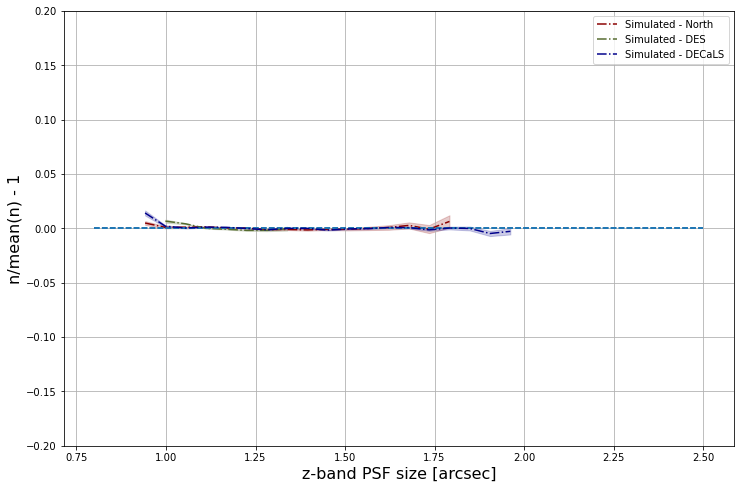

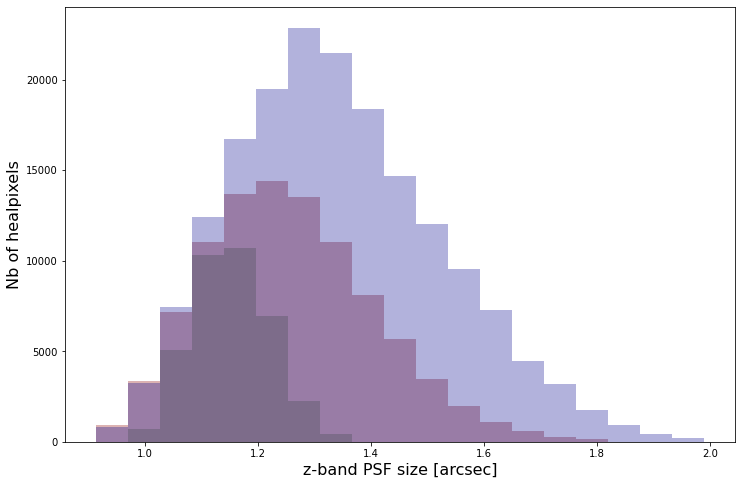

In [89]:
"""PSF size z"""

plt.figure()

min_x = 0.8
max_x = 2.50
binsize = (max_x-min_x)/30

# x_axis_1N, mean_value_1N, std_value_1N, nb_pix_1N = compute_density_bin(density_1N, t1N["PSFSIZE_Z"], min_x, max_x, binsize, mean_density_1N, minbin)
# plot_curve_density(x_axis_1N, mean_value_1N, std_value_1N, min_x, max_x, -0.5, 0.5, 'r', 'North')
# x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, nb_pix_1Sdes = compute_density_bin(density_1Sdes, t1Sdes["PSFSIZE_Z"], min_x, max_x, binsize, mean_density_1Sdes, minbin)
# plot_curve_density(x_axis_1Sdes, mean_value_1Sdes, std_value_1Sdes, min_x, max_x, -0.5, 0.5, 'g', 'South, DES')
# x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, nb_pix_1Sdecals = compute_density_bin(density_1Sdecals, t1Sdecals["PSFSIZE_Z"], min_x, max_x, binsize, mean_density_1Sdecals, minbin)
# plot_curve_density(x_axis_1Sdecals, mean_value_1Sdecals, std_value_1Sdecals, min_x, max_x, -0.5, 0.5, 'b', 'South, DECaLS')

x_axis_mcN, mean_value_mcN, std_value_mcN, nb_pix_mcN = compute_density_bin(densmcN, tmcN["PSFSIZE_Z"], min_x, max_x, binsize, mean_density_mcfN, minbin)
plot_curve_density(x_axis_mcN, mean_value_mcN, std_value_mcN, min_x, max_x, -0.5, 0.5, 'darkred',  'Simulated - North', 'dashdot')
x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, nb_pix_mcSdes = compute_density_bin(densmcSdes, tmcSdes["PSFSIZE_Z"], min_x, max_x, binsize, mean_density_mcfSdes, minbin)
plot_curve_density(x_axis_mcSdes, mean_value_mcSdes, std_value_mcSdes, min_x, max_x, -0.5, 0.5, 'darkolivegreen',  'Simulated - DES', 'dashdot')
x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, nb_pix_mcSdecals = compute_density_bin(densmcSdecals, tmcSdecals["PSFSIZE_Z"], min_x, max_x, binsize, mean_density_mcfSdecals, minbin)
plot_curve_density(x_axis_mcSdecals, mean_value_mcSdecals, std_value_mcSdecals, min_x, max_x, -0.5, 0.5, 'darkblue',  'Simulated - DECaLS', 'dashdot')

# x_axis_2N, mean_value_2N, std_value_2N, nb_pix_2N = compute_density_bin(density_2N, t2N["PSFSIZE_G"], min_x, max_x, binsize, mean_density_2N, 200)
# plot_curve_density(x_axis_2N, mean_value_2N, std_value_2N, min_x, max_x, -0.5, 0.5, 'orange', 'Guadalupe - North')
# x_axis_2S, mean_value_2S, std_value_2S, nb_pix_2S = compute_density_bin(density_2S, t2S, min_x, max_x, binsize, mean_density_2S, 200)
# plot_curve_density(x_axis_2S, mean_value_2S, std_value_2S, min_x, max_x, -0.5, 0.5, 'y', 'Guadalupe - South')

plt.grid(True)
plt.ylim(-0.2,0.2)
plt.xlabel("z-band PSF size [arcsec]", size=16)
plt.ylabel("n/mean(n) - 1", size=16)
plt.legend()
# plt.savefig('galdepth-z.png', bbox_inches='tight')

plt.figure()
# plot_histogram_bin(x_axis_1N, nb_pix_1N, binsize, color='r')
# plot_histogram_bin(x_axis_1Sdes, nb_pix_1Sdes, binsize, color='g')
# plot_histogram_bin(x_axis_1Sdecals, nb_pix_1Sdecals, binsize, color='b')
plot_histogram_bin(x_axis_mcN, nb_pix_mcN, binsize, color='darkred')
plot_histogram_bin(x_axis_mcSdes, nb_pix_mcSdes, binsize, color='darkolivegreen')
plot_histogram_bin(x_axis_mcSdecals, nb_pix_mcSdecals, binsize, color='darkblue')
# plot_histogram_bin(x_axis_2N, nb_pix_2N, binsize, color='g')
# plot_histogram_bin(x_axis_2S, nb_pix_2S, binsize, color='y')

plt.xlabel("z-band PSF size [arcsec]", size=16)
plt.ylabel("Nb of healpixels", size=16)
#plt.savefig('galdepth-z-bins.png', bbox_inches='tight')

# 4 - Reshift distribution (only if truth sample = HSC)

This section aims to show the redshift distribution of the ELGs. It has to be compared with the initial one in the truth sample. NB: the simulation is not tuned to perform a good redshift distribution, but it can be observed as an output of the simulation.

In [15]:
nz = np.load("MC_results/MC_elg_lop_eps=0.7_1_withnz_nz.npy")
zbins = np.load("MC_results/MC_elg_lop_eps=0.7_1_withnz_zbins.npy"

In [40]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [39]:
dn = np.array([np.array([nz[i][j+1] - nz[i][j] for j in range(len(nz[i])-1)]) for i in range(len(nz))])
dn_relat = np.array([np.array([((nz[i][j+1] - nz[i][j])/nz[i][j]) if nz[i][j]>0 else 0 for j in range(len(nz[i])-1)]) for i in range(len(nz))])
nzall = np.mean(nz, axis=0)
dnall = np.mean(dn, axis=0)
dn_relatall = np.mean(dn_relat, axis=0)

In [41]:
nzsmooth = smooth(nz[0], 8)
nzallsmooth = smooth(nzall, 8)
dnrelatsmooth = smooth(dn_relat[27500], 8)
dnallrelatsmooth = smooth(dn_relatall, 8)

<BarContainer object of 66 artists>

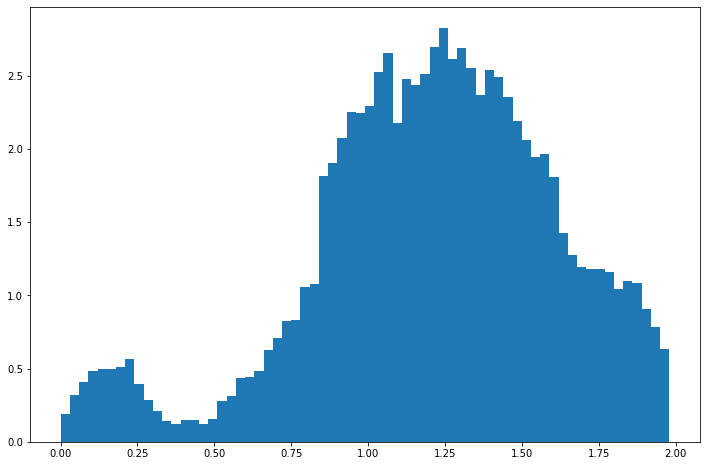

In [42]:
zbins2plot = [(zbins[i]+zbins[i+1])/2 for i in range(len(zbins)-1)]
plt.bar(zbins2plot, height=nzallsmooth, width=zbins[1]-zbins[0], align='center')

(0.6, 1.5)

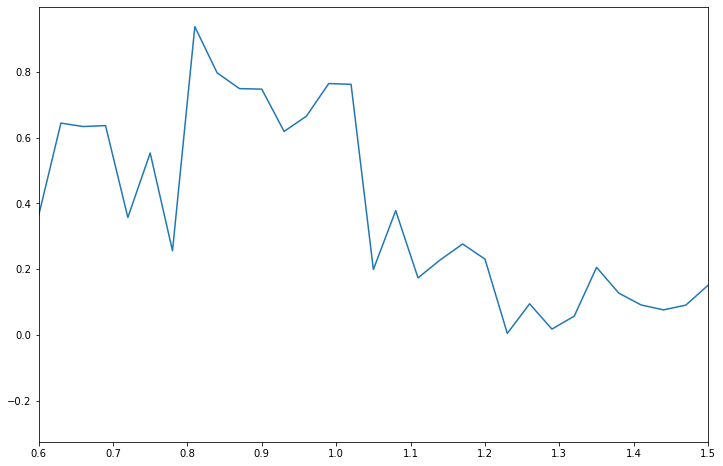

In [43]:
#plt.plot(zbins[:-2], dn[0])
plt.plot(zbins[:-2], dnallrelatsmooth)
plt.xlim(0.6, 1.5)

# 5 - DR9 Maps

To finish, some features of the ELG target DR9 map are showed, as well as the relation that was used to fit the true computed depth (see report) with the PSF and the Galaxy depths.

## Regions

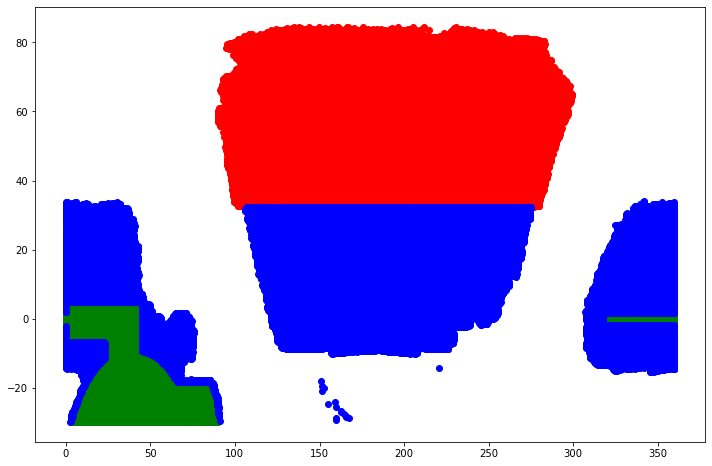

In [148]:
plt.scatter(tmcN["RA"], tmcN["DEC"], c='r', label="North (BASS & MzLS)")
plt.scatter(tmcSdes["RA"], tmcSdes["DEC"], c='g', label="South DES")
plt.scatter(tmcSdecals["RA"], tmcSdecals["DEC"], c='b', label="South DECAM")

## Density map with high quality

In [ ]:
vmin=0.4
vmax=1.6
mean_dens = np.mean(density)
plot_map(t1reduced["HPXPIXEL"], t1reduced["N_ELG_LOP"]/eff_area(t1reduced, '_in_LS')/np.mean(t1reduced["N_ELG_LOP"]/eff_area(t1reduced, '_in_LS')), nside, vmin, vmax)

## Extinction

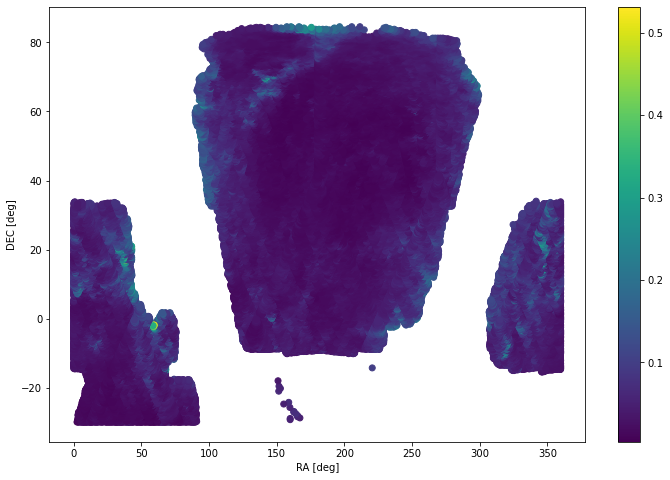

In [158]:
plt.scatter(tmc["RA"],tmc["DEC"],c=tmc["EBV"])
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.colorbar()

## Depth in g-band

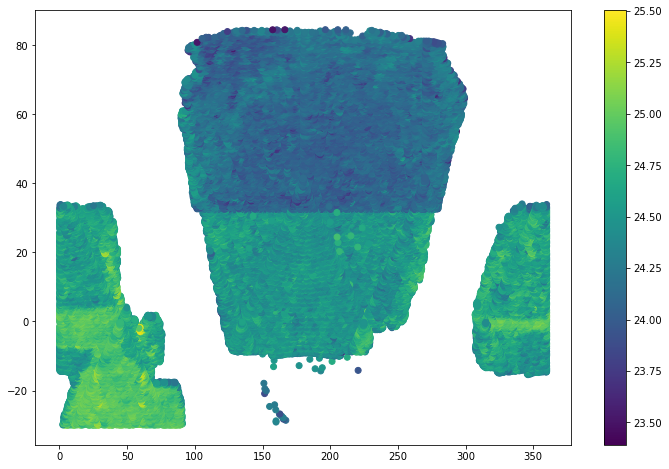

In [161]:
plt.scatter(t1["RA"],t1["DEC"],c=-2.5 * (np.log10(5/np.sqrt(t1["GALDEPTH_G_in_LS"])) - 9), s=4)
plt.colorbar()

## Fit the true depth and the galaxy depth

In [ ]:
def f_depth(xtuple, eps):
    (x, y) = xtuple
    return (1/x) * (1+eps/y**2)

from scipy.optimize import curve_fit

In [ ]:
side_x, side_y = t1["PSFDEPTH_G"], t1["PSFSIZE_G_in_LS"]
x_data = np.zeros((2,len(t1)))
for i in range(len(t1)):
        x_data[0,i] = t1["PSFDEPTH_G"][i]
        x_data[1,i] = t1["PSFSIZE_G_in_LS"][i]
X1, X2 = np.meshgrid(side_x, side_y)

y_data = np.array((1/t1["GALDEPTH_G"]))
eps_opt = curve_fit(f_depth, x_data, y_data)
print(eps_opt)

In [ ]:
plt.figure(figsize=(8,8))
plt.xlabel("sigma_PSF² [nanomaggies²]")
plt.ylabel("sigma_depth² [nanomaggies²]")
#true_depth = (1/t1reduced["PSFDEPTH_G"]) * (1+epsi[i]/t1reduced["PSFSIZE_G_in_LS"]**2)
plt.scatter((1/tmc["PSFDEPTH_G"]), 1/tmc["TRUE_DEPTH_G"], label='Computed depth (var)')
plt.scatter((1/t1reduced["PSFDEPTH_G"]), (1/t1reduced["PSFDEPTH_G"]), c='r', label='PSF depth (var)')
plt.scatter((1/t1reduced["PSFDEPTH_G"]), (1/t1reduced["GALDEPTH_G"]), c='g', label='Galaxy depth (var)')
plt.legend()

In [ ]:

epsi = np.linspace(0., 3., 10)
# plt.figure()
# true_depth = (1/t1reduced["PSFDEPTH_G"]) * (1+eps_opt[0]/t1reduced["PSFSIZE_G_in_LS"]**2)
# plt.scatter((1/t1reduced["PSFDEPTH_G"]), true_depth)
# plt.scatter((1/t1reduced["PSFDEPTH_G"]), (1/t1reduced["PSFDEPTH_G"]), c='r')
# plt.scatter((1/t1reduced["PSFDEPTH_G"]), (1/t1reduced["GALDEPTH_G"]), c='g')
for i in range(10):
    plt.figure(figsize=(6,6))
    plt.xlabel("sigma_PSF² [nanomaggies²]")
    plt.ylabel("sigma_depth² [nanomaggies²]")
    true_depth = (1/t1reduced["PSFDEPTH_G"]) * (1+epsi[i]/t1reduced["PSFSIZE_G_in_LS"]**2)
    plt.scatter((1/t1reduced["PSFDEPTH_G"]), true_depth, label='Computed depth (var)')
    plt.scatter((1/t1reduced["PSFDEPTH_G"]), (1/t1reduced["PSFDEPTH_G"]), c='r', label='PSF depth (var)')
    plt.scatter((1/t1reduced["PSFDEPTH_G"]), (1/t1reduced["GALDEPTH_G"]), c='g', label='Galaxy depth (var)')
    plt.legend()
    print(epsi[i])